This file is being used to test variable window length's during the dvv process to determine which length is the most appriopriate to capture the coda wave in it's entirety.

In [57]:
#IMPORT SECTION
import sys,os,time,glob,scipy
import pandas as pd
from obspy import UTCDateTime
import pyasdf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pylab as pl
from scipy.optimize import curve_fit
from seisgo import noise, monitoring, utils
import seisgo.plotting as sp
import seisgo.downloaders as dld
import pickle
import datetime 
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rc('font',family='Helvetica')
np.set_printoptions(threshold=sys.maxsize)

In [58]:
#####GSI FILE LOCATIONS#####    
maindirec  = 'data_greatsitkin' #main project folder
figdir = os.path.join('Figures')
dvvdir  = os.path.join(maindirec,'dvv_winlentests')


In [59]:
sta_list = ['AV.GSSP']

method = 'ts'
#FREQUENCIES#
freq = [1,2]
freqtag=str(freq[0])+'-'+str(freq[1])+'Hz'
comppair = 'SC'           # write 'SC' for same comp or 'XC' cross comp
offsets = list(np.arange(2,50,5))
winlen = list(np.arange(5,20,1))

testparameter = winlen.copy()


wtsfreqrange = [1,2]    ##select wts freq range for the plot should be subset of freqr

sdate='2019-07-01'
sdate_num=mdates.datestr2num(sdate)
edate='2022-04-04'
edate_num=mdates.datestr2num(edate)
threecompdates_series=np.arange(sdate_num,edate_num,.5) #0.5: half day. original dv/v resolution.
sdateref="2019-07-05"
edateref="2020-02-01"
xx_ref_start = mdates.datestr2num(sdateref)
xx_ref_end = mdates.datestr2num(edateref)

###################
###PARAMETERS THAT TYPICALLY DONT NEED CHANGING######
##CHANGE datanum to 'data1' or 'data2'
# to pick positive or negative side
# data1 = negative, data2 = positive
# 'both' will average both sides
datanum = 'both' 
#Change this option
#full window legnth in days
full_window_length = 20
## Calculating the Moving Window Mean
# Original resolution is 12 hours (3/25/2022)
#It may seem redundent but the first '2' is for the resolution being a 1/2 day
# and converting it to a full day. The second '2' is cutting the window to only
#one side. keep both for clarity and if you need to change the original resolution
window = 2*int(full_window_length/2)
# Minimum correlation coefficient and maximum error thresholds
mincc = 0.75
maxerr = 1
sta_dict = {}

In [60]:
offset=1
if comppair == "XC":
    complist = ['EZ','NZ','EN']
elif comppair == "SC":
    complist = ['EE','NN','ZZ']
for sta in sta_list:
    
    for par in testparameter:

        source = sta
        receiver = source
        offs = offset
        #PICK FROM FILE PARAMETER OPTIONS
        dvvfilelist=[]
        
        for c in complist:
            compfilename='dvv.'+source+'.'+receiver+'.'+c+'.'+str(par)+\
                '.'+freqtag+'.'+method+'.pk'
            compdvvfilepath=os.path.join(dvvdir, compfilename)
            comptempdvvfile = monitoring.extract_dvvdata(compdvvfilepath, comp=c, format = 'pickle')
            dvvfilelist.append(comptempdvvfile[source+'_'+receiver][c])
        
        compdict = {}
        for idx, compfile in enumerate(dvvfilelist):
        ###OPTION 1####
        ###pick the dvv file to use
            dvvdata = compfile

            if datanum is None:
                neg = sum(dvvdata.maxcc1)/len(dvvdata.maxcc1)
                pos = sum(dvvdata.maxcc2)/len(dvvdata.maxcc2)
                if neg >= pos:
                    datanum = 'data1'
                else:
                    datanum = 'data2'


            ###########################################################
            ###############Parameters for both#########################
            posneg = ''
            ####################### wts ###############################
            ##### filter out frequency and low correlation coeffecients
            if method == 'wts':
                if datanum == 'data1':
                    posneg = '(negative)'

                    data1temp0 = dvvdata.data1
                    data1temp0[dvvdata.maxcc1 <= mincc ] = np.nan

                    freqidx = np.where(((dvvdata.freq>=wtsfreqrange[0]) & (dvvdata.freq<=wtsfreqrange[1])))[0]
                    data = data1temp0[:,freqidx]

                elif datanum == 'data2':
                    posneg = '(positive)'

                    data2temp0 = dvvdata.data2
                    data2temp0[dvvdata.maxcc2 <= mincc ] = np.nan


                    freqidx = np.where(((dvvdata.freq>=wtsfreqrange[0]) & (dvvdata.freq<=wtsfreqrange[1])))[0]
                    data = data2temp0[:,freqidx]

                elif datanum == 'both':
                    posneg = ''

                    data1temp0 = dvvdata.data1
                    data1temp0[dvvdata.maxcc1 <= mincc ] = np.nan

                    freqidx = np.where(((dvvdata.freq>=wtsfreqrange[0]) & (dvvdata.freq<=wtsfreqrange[1])))[0]
                    data1 = data1temp0[:,freqidx]
                    print(len(data1))

                    data2temp0 = dvvdata.data2
                    data2temp0[dvvdata.maxcc2 <= mincc ] = np.nan


                    freqidx = np.where(((dvvdata.freq>=wtsfreqrange[0]) & (dvvdata.freq<=wtsfreqrange[1])))[0]
                    data2 = data2temp0[:,freqidx]

                    data = (data1+data2)/2
                #
                freqrange = wtsfreqrange

            ############################################################
            ####################### ts ###############################
            #####low correlation coeffecients
            elif method == 'ts':
                if datanum == 'data1':
                    posneg = '(negative)'

                    data1temp = dvvdata.data1
                    data1temp[dvvdata.maxcc1 <= mincc ] = np.nan
                    data1temp[dvvdata.error1 >= maxerr ] = np.nan
                    data = data1temp

                elif datanum == 'data2':
                    posneg = '(positive)'

                    data2temp = dvvdata.data2
                    data2temp[dvvdata.maxcc2 <= mincc ] = np.nan
                    data2temp[dvvdata.error2 >= maxerr ] = np.nan
                    data = data2temp

                elif datanum == 'both':
                    posneg = ''

                    data1temp = dvvdata.data1
                    data1temp[dvvdata.maxcc1 <= mincc ] = np.nan
                    data1temp[dvvdata.error1 >= maxerr ] = np.nan
                    data1=data1temp

                    data2temp = dvvdata.data2
                    data2temp[dvvdata.maxcc2 <= mincc ] = np.nan
                    data2temp[dvvdata.error2 >= maxerr ] = np.nan
                    data2=data2temp

                    data = (data1+data2)/2

            ############################################################

            ####Creating a date list of numbers to
            #### be used in the scipy.optimize.curve_fit
            ####getting datetime from the data###
            dates = dvvdata.time

            numdatelist0 = []
            for i in dates:
                numdatelist0.append(i)

            strdatelist0 = []
            for i in range(len(dates)):
                da = datetime.datetime.utcfromtimestamp(dates[i]).strftime('%Y-%m-%d %H:%M')
                strdatelist0.append(da)


            ###get the mean from the frequency band###
            ############### for wts ##################
            ### this has no effect if method used is
            ## ts. Leave it if ts because datalist is
            ## the variable used to calculate curve_fit
            datalist0 = []
            for i in range(len(data)):
                datamean = np.average(data[i])
                datalist0.append(datamean)

            ## Removing NaN values and their associated dates
            ## by indices

            datalist = []
            numdatelist = []
            strdatelist = []
            datesremoved = []

            for i in range(len(dates)):
                datapoint = datalist0[i]
                if np.isnan(datapoint) == False:
                    datalist.append(datalist0[i])
                    numdatelist.append(numdatelist0[i])
                    strdatelist.append(strdatelist0[i])
                else:
                    datesremoved.append(strdatelist0[i])

            ### MDATES
            mdateslist = list(mdates.date2num(strdatelist))


            #How many point where removed
            # print(comppair," offset in seconds:",offset)
            # print("Number of data points remaining:",len(datalist))
            # print("NaN points detected and removed:",len(datalist0)-len(datalist))
            # print()
            #print('Dates Removed:',datesremoved)

            ##detrend data
            # data_0 = utils.detrend(utils.demean(np.array(datalist)))
            data_0 = np.array(datalist)

            compdata = data_0
            compmdateslist = mdateslist

            compdict[complist[idx]] = [compmdateslist, compdata]
        #########################################################
        #################  dvv data compiling.  #################
        #########################################################
        ### 3 comp average data plot

        dateslength=max(len(compdict[complist[0]][0]),len(compdict[complist[1]][0]),\
                        len(compdict[complist[2]][0]))

        
        threecompdata_0 = []

        for idx, date3comp in enumerate(threecompdates_series):
            x = np.nan
            y = np.nan
            z = np.nan
            if date3comp in compdict[complist[0]][0]:
                comp1idx = compdict[complist[0]][0].index(date3comp)
                x = compdict[complist[0]][1][comp1idx]
            if date3comp in compdict[complist[1]][0]:
                comp2idx = compdict[complist[1]][0].index(date3comp)
                y= compdict[complist[1]][1][comp2idx]
            if date3comp in compdict[complist[2]][0]:
                comp3idx = compdict[complist[2]][0].index(date3comp)
                z = compdict[complist[2]][1][comp3idx]
            threecompdata_0.append(np.nanmean([x,y,z]))

        #removing Nans and associated dates for MWM
        threecompdates = []
        threecompdata = []

        for idx, val in enumerate(threecompdata_0):
            if np.isnan(val) == False:
                threecompdata.append(threecompdata_0[idx])
                threecompdates.append(threecompdates_series[idx])



        data_MWM = utils.moving_ave(np.array(threecompdata),window)
        sta_dict[sta+'.'+str(par)] = [threecompdates,data_MWM]

/var/folders/1p/583wb0yd6cz2s_pfhqk807xm0000gn/T/ipykernel_87235/1723164633.py:206: RuntimeWarning: Mean of empty slice
  threecompdata_0.append(np.nanmean([x,y,z]))


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


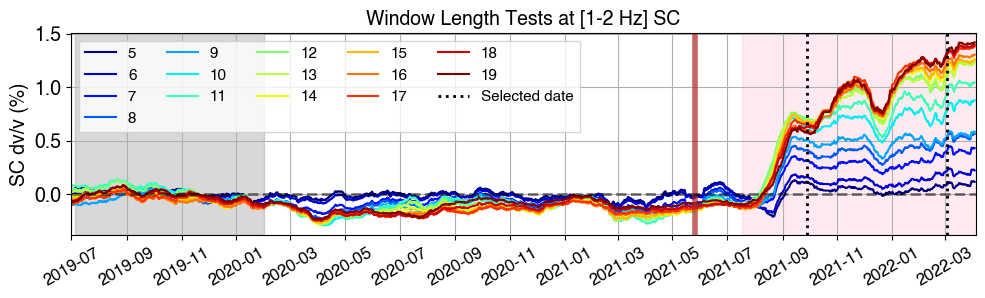

In [61]:
##########FULL DATA RANGE##############
##########PLOTTING######################
dateselect=['2021-09-28','2022-03-03']

fig, axs = plt.subplots(figsize = (10,3), facecolor = 'white')

color = pl.cm.jet(np.linspace(0,1,len(sta_dict)))
#Curve Fit Plot
for idx,key in enumerate(sta_dict):
     axs.plot(sta_dict[key][0], sta_dict[key][1], color = color[idx], label = str(testparameter[idx]))


#axs.set_ylabel("change in velocity (%)", fontsize = 20)
axs.axvspan(xx_ref_start,xx_ref_end, alpha=.3, color = 'gray')
axs.axvline(mdates.datestr2num("2021-05-26"), color = 'firebrick',\
            linewidth = 4,linestyle = '-', alpha=0.7)

axs.axvspan(mdates.datestr2num("2021-07-18"),edate_num, alpha=.3, color = 'pink')

for i,strdate in enumerate(dateselect):
    xx = mdates.datestr2num(strdate)
    if i ==0:
        axs.axvline(xx,color = 'k',\
               linewidth = 2,linestyle = ':', label = 'Selected date')
    else:
        axs.axvline(xx,color = 'k',linewidth = 2,linestyle = ':')
axs.axhline(0,linewidth = 2, linestyle = '--', color = "black", alpha = .5)
abs_minlist = []
for key in sta_dict:
    min = np.min(sta_dict[key][1])
    abs_minlist.append(min)
abs_min = np.min(abs_minlist)

axs.set_xlim(sdate_num, edate_num)
axs.grid()
axs.label_outer()
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axs.tick_params(axis='x', labelsize=12)
axs.tick_params(axis = 'y', labelsize=14)
axs.set_ylabel(comppair+' dv/v (%)', fontsize = 14)

figname = "Window Length Tests at [1-2 Hz] "+comppair

axs.set_title(figname, fontsize =14)
fig.tight_layout()
fig.autofmt_xdate(rotation=30,ha='center')
axs.legend(loc='upper left',ncol=5, fancybox=False,shadow=False, prop={'size':11})

plt.savefig(os.path.join(figdir, 'WinLenTests_'+freqtag+'_GSSP_'+comppair+'.pdf'), format = 'pdf', dpi=300 )
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


2021-09-28
working...
completed.
[0.1146, 0.1628, 0.3164, 0.4112, 0.5044, 0.6315, 0.6988, 0.7114, 0.6918, 0.6715, 0.6773, 0.5957, 0.6574, 0.6318, 0.577]
2022-03-03
working...
completed.
[0.0868, 0.2153, 0.4048, 0.5181, 0.5347, 0.774, 0.9354, 1.0998, 1.0797, 1.1647, 1.1955, 1.2333, 1.3009, 1.3055, 1.3235]


/var/folders/1p/583wb0yd6cz2s_pfhqk807xm0000gn/T/ipykernel_87235/1690651596.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


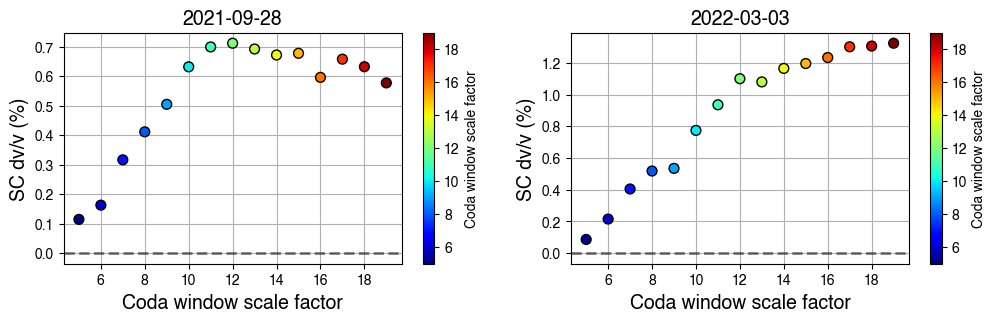

In [62]:
# for idx, val enumerate(freq0threecompdates, freq0data_MWM):
#     if freq0threecompdates[idx] == 18982:
#         print(freq0data_MWM)
# strdate = '2021-09-28'
fig, axs = plt.subplots(1,len(dateselect),figsize = (12,3),\
                            facecolor = 'white')
for i,strdate in enumerate(dateselect):
    xx = mdates.datestr2num(strdate)

    print(strdate)
    dvvval = []

    print("working...")

    for key in sta_dict:
        for idx, val in enumerate(sta_dict[key][0]):
            if sta_dict[key][0][idx] == xx:
                dvvval.append(round(sta_dict[key][1][idx],4))

    print("completed.")
    print(dvvval)

    
    sct=axs[i].scatter(winlen,dvvval, c=winlen,cmap = 'jet', s=50,edgecolors='k')
    axs[i].set_xlabel('Coda window scale factor', fontsize = 14)
    axs[i].set_ylabel(comppair+' dv/v (%)', fontsize = 14)
    axs[i].axhline(0,linewidth = 2, linestyle = '--', color = "black", alpha = .5)
    axs[i].grid()
    axs[i].set_title(strdate,fontsize=14)
    axs[i].set_axisbelow(True)
    fig.colorbar(sct,ax=axs[i],label='Coda window scale factor')
#
fig.savefig(os.path.join(figdir, 'WinLenTests_'+freqtag+'_GSSP_'+comppair+'_selecteddates.pdf'), format = 'pdf', dpi=300 )
fig.show()

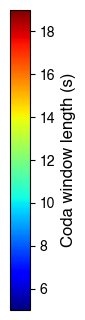

In [63]:
a = np.array([winlen])
plt.figure(figsize=(0.25, 5))
img = pl.imshow(a, cmap="jet")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="vertical", cax=cax)
plt.ylabel('Coda window length (s)', size=12)
plt.show()